In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
import random
from google.colab.patches import cv2_imshow
from google.colab import files
from matplotlib import figure
from tqdm import tqdm

In [183]:
def get_ANMScorners(grayimage,N_best, min_dist):
  dst = cv.cornerHarris(grayimage,2,3,0.04)

  anms_img = []
  anms_corners = []

  local_maximas = peak_local_max(dst, min_dist,exclude_border=20)
  n_strong = local_maximas.shape[0]
  r = [np.Infinity for i in range(n_strong)]
  x=np.zeros((n_strong,1))
  y=np.zeros((n_strong,1))
  eu_dist = 0
  
  for i in range(n_strong):
    x_i = local_maximas[i][0]
    y_i = local_maximas[i][1]
    for j in range(n_strong):
      x_j = local_maximas[j][0]
      y_j = local_maximas[j][1]
      
      if(dst[x_j, y_j] > dst[x_i, y_i]):
        eu_dist = np.square(x_j - x_i) + np.square(y_j - y_i)
      if r[i] > eu_dist:
        r[i] = eu_dist
        x[i] = x_j
        y[i] = y_j
        
  index = np.argsort(r)
  index = np.flip(index)
  index = index[0:N_best]
  if x.shape[0] < N_best:
    N_best = x.shape[0]
    
  x_best=np.zeros((N_best,1))
  y_best=np.zeros((N_best,1))
  
  for i in range(N_best):
    x_best[i] = np.intp(y[index[i]])
    y_best[i] = np.intp(x[index[i]]) 
    cv.circle(grayimage, (int(x_best[i]), int(y_best[i])), 3, (0, 255, 0), -1)
    
  anms_corner = np.intp(np.concatenate((x_best, y_best), axis = 1))
  anms_corners.append(anms_corner)
  cv2_imshow(grayimage)
  cv.imwrite("anms.png",grayimage)
  return anms_img,anms_corner

In [195]:
def FeatureDesc(anms_corner,grayimage):
	feature_desc = []
	grayimage = cv.GaussianBlur(grayimage,(3,3),1)
	size_x,size_y = np.shape(grayimage)
	for features in anms_corner:
		reqpatch = grayimage[max(0,features[1]-20):min(size_x,features[1]+20):5,max(0,features[0]-20):min(size_y,features[0]+20):5]
		# reqpatch.astype(float)
		if np.size(reqpatch) == 64:
			# print(reqpatch.shape)
			feature_desc.append(reqpatch)  
	plt.figure() 
	# print('shape of patch list:', np.shape(feature_desc))
	vec = []
	for r, im in enumerate(feature_desc):
		# im = cv.GaussianBlur(im,(3,3),0)
		im = np.array(im).reshape(64,1)
		im = im - np.mean(im)
		var = np.var(im)
		if var>60:
			m_abs= im/np.sqrt(var)
			# m = im/ np.max(im)


			vec.append(m_abs)
			# print(np.shape(im))
		# 	# print('im\n=',m_abs)
		# 	plt.subplot(30,30,r+1)
		# 	plt.imshow(np.array(im).reshape(8,8))
		# 	# plt.suptitle('patches for image ' + st)
		# 	plt.axis("off")
		# 	# plt.savefig("featudesc")
		# plt.show()
	return vec



In [4]:

def Feature_Match(fvector1, fvector2,ratio):
    keypoint1 = list()
    keypoint2 = list()
    matches = []
    count = np.zeros(2000)
    for i in range(len(fvector1)):
        lowest = None
        secondlowest = None
        lowestidx = None
        dists = []
        for j in range(len(fvector2)):
            dist = np.sum((fvector1[i]-fvector2[j])**2)
            dists.append(dist)
            # print(dist)
            if(lowest is None or dist<=lowest):
                secondlowest = lowest
                lowest = dist
                lowestidx = j
            elif(dist>lowest and (secondlowest is None or dist<secondlowest )):
                secondlowest = dist
            # print(lowest)
            # print(secondlowest)
        # while secondlowest is not None:
        if(float(lowest)/float(secondlowest)<ratio):
            keypoint1.append(lowest)
            keypoint2.append(secondlowest)
            matches.append((i,lowestidx))
            count[lowestidx] += 1
        dists.sort()
        # print(dists)
        # print(lowest/secondlowest)
    return matches, keypoint1, keypoint2,count

In [189]:
def checkpairs(rand_list,point1,point2):
    dst = np.zeros((4,2),dtype=np.float32)
    src = np.zeros((4,2),dtype=np.float32)
    for i in range(rand_list.shape[0]):
        dst[i,:] = point2[rand_list[i]][:]
        src[i,:] = point1[rand_list[i]][:]
    trasform_mat = cv.getPerspectiveTransform(src,dst)
    sdd = 0
    src_cd = np.ones((3,1),dtype=np.float32)
    for i in range(point1.shape[0]):
        src_cd[0,0]=point1[i][0]
        src_cd[1,0]=point1[i][1]
        new_cd = np.matmul(trasform_mat,src_cd)
        sdd += np.sum((new_cd[0:2].T-point2[i][:])**2)
    # print(sdd)
    return sdd,trasform_mat

def filterOutliers(key1a,key2a,gray,gray2):#(matched_pairs, outliers, accuracy, thresh):
    TMF = []
    iterations = 1000
    bestsdd = 1e14    
    count = np.zeros(key1a.shape[0])
    for i in range(iterations):
        # if(key1a.shape[0]<8):
        #   break
        n_rows = key1a.shape[0]
        # print(n_rows)
        random_indices = np.random.randint(n_rows, size=4)
        chk,tm = checkpairs(random_indices,key2a,key1a)
    
        if chk<bestsdd:
            bestsdd = chk
            TMF = tm
        # lst.append(chk)
        # incval = 1
        if chk> 1e11/(i+1):
            for j in random_indices:
                count[j] += 1
            j = random_indices
            # nw1 = np.delete(key1a,j,0)
            # nw2 = np.delete(key2a,j,0)
            # nw3 = np.delete(count,j)
            # key1a = nw1
            # key2a = nw2
            # count = nw3
        
    key1 = []
    key2 = []
    for i in range(key1a.shape[0]):
        key1.append(key1a[i][:])
        key2.append(key2a[i][:])
    key1b = np.array(key1,dtype=float)
    key2b = np.array(key2,dtype=float)
    cv_kpts1 = [cv.KeyPoint(key1b[i][0], key1b[i][1], 1) for i in range(key1b.shape[0])]
    cv_kpts2 = [cv.KeyPoint(key2b[i][0], key2b[i][1], 1) for i in range(key2b.shape[0])]
    # print(key1)
    # print(key2)
    drawout = np.array([])
    good_matches = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx,_distance=0) for idx in range(np.shape(key1b)[0])]
    drawout = cv.drawMatches(np.uint8(gray),cv_kpts1,np.uint8(gray2),cv_kpts2,good_matches,outImg=drawout)
    # print(drawout)
    cv2_imshow(drawout)
    cv.imwrite("matching.png",drawout)
    cv.waitKey(0)
    ordd = np.argsort(count)
    key1c = []
    for i in ordd:
        key1c.append([key1b[i],key2b[i]])
    return key1b,key2b,TMF



In [191]:
def stitch_img(image1 ,image2, h_best):


    # new_h = np.array([h_best[1,:],h_best[0,:],h_best[2,:]]).T
    # # print(new_h.T)
    # neww = np.array([new_h[1,:],new_h[0,:],new_h[2,:]]).T
    # h_best=neww

    height_1, width_1,_= np.shape(image1)
    height_2,width_2,_ = np.shape(image2)
    pt1 = np.array([[0, width_1, width_1, 0], [0, 0, height_1, height_1], [1, 1, 1, 1]])
    p_dash = np.dot(h_best, pt1)

    p_dashxy = p_dash / p_dash[2]
    xrow = p_dashxy[0]
    yrow = p_dashxy[1]
    ymin = min(yrow)
    xmin = min(xrow)
    ymax = max(yrow)
    xmax = max(xrow)
    
    newh = np.array([[1, 0, -1 * xmin], [0, 1, -1 * ymin], [0, 0, 1]])    # Make new matrix that removes offset and multiply by homography

    # height = int(round(ymax - ymin))+height_2   # height and width of new image frame
    # width = int(round(xmax - xmin))+ width_2
    # size = (height_2*2,width_2*2)
    # size = (1200,900)
    size = (int(max(xmax,width_2-xmin)),int(max(ymax,height_2-ymin)))
    
    warped_image = cv.warpPerspective(image1, newh.dot(h_best), dsize=size)    #Warpigng
    wx,wy,_ = warped_image.shape
    xstart = 0
    ystart = 0
    if xmin>0:
      xstart = int(xmin)
      xmin = 0
    if ymin>0:
      ystart = int(ymin)
      ymin = 0
    new_warped = np.zeros((ystart + wx,xstart + wy,3))
    new_warped = new_warped.astype(np.uint8)
    new_warped[ystart:ystart + wx,xstart:xstart + wy,:] = warped_image
    return new_warped, int(xmin), int(ymin)

In [190]:
def blending(image3,img1,tmf3):
    
      stitch12,xmin,ymin = stitch_img(image3 ,img1, tmf3)        # a=0
       
      print(img1.shape)
      print(xmin)
      print(ymin)
      print(stitch12.shape)
      
      black1 = stitch12
      black2 = np.zeros((stitch12.shape))
      black2[abs(ymin):abs(ymin)+img1.shape[0],abs(xmin):img1.shape[1]+abs(xmin)] = img1
      neww3 =  black2*0.5 + black1*0.5


      # neww = black/2 + Ib/2

      for i in range(black1.shape[0]):
        for j in range(black1.shape[1]):
          
          if np.sum(black1[i,j,:]) == 0:
            neww3[i,j,:] = black2[i,j,:]

          if np.sum(black2[i,j,:]) == 0 :
            neww3[i,j,:] = black1[i,j,:]
     
        

        # temp_save[abs(y_min):i.shape[1]+abs(y_min),abs(x_min):abs(x_min)+i.shape[0]] = i
      cv2_imshow(neww3)
      cv.imwrite("mypano.png",neww3)
      return neww3


# SET 1:

In [168]:
uploaded = files.upload()

Saving 3.jpg to 3 (2).jpg
Saving 1.jpg to 1 (2).jpg
Saving 2.jpg to 2 (2).jpg


In [192]:
#Read Images
image1 = cv.imread("1 (2).jpg") ###1.png 
gray1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
gray1 = cv.normalize(gray1,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

image2 = cv.imread("2 (2).jpg")
gray2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
gray2 = cv.normalize(gray2,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

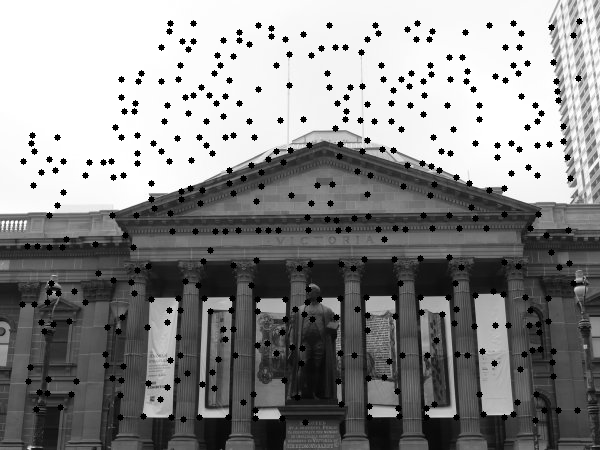

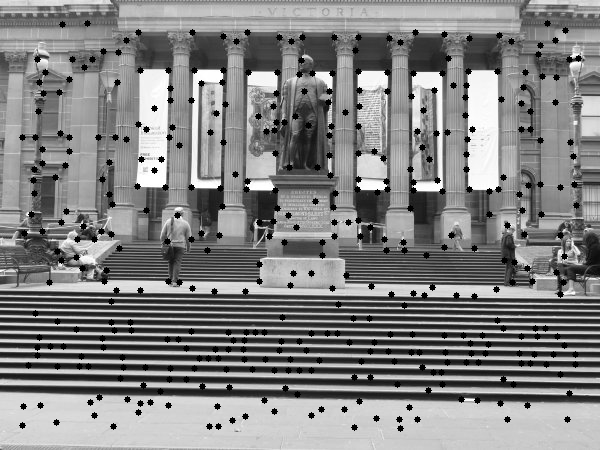

In [193]:
#Get ANMS Corners
anms_img1, anms_corners1 = get_ANMScorners(gray1, 1100, 7)
anms_img2, anms_corners2 = get_ANMScorners(gray2,1100,7)


In [196]:
vec1 = FeatureDesc(anms_corners1,gray1)
vec2 = FeatureDesc(anms_corners2,gray2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(41, 2)


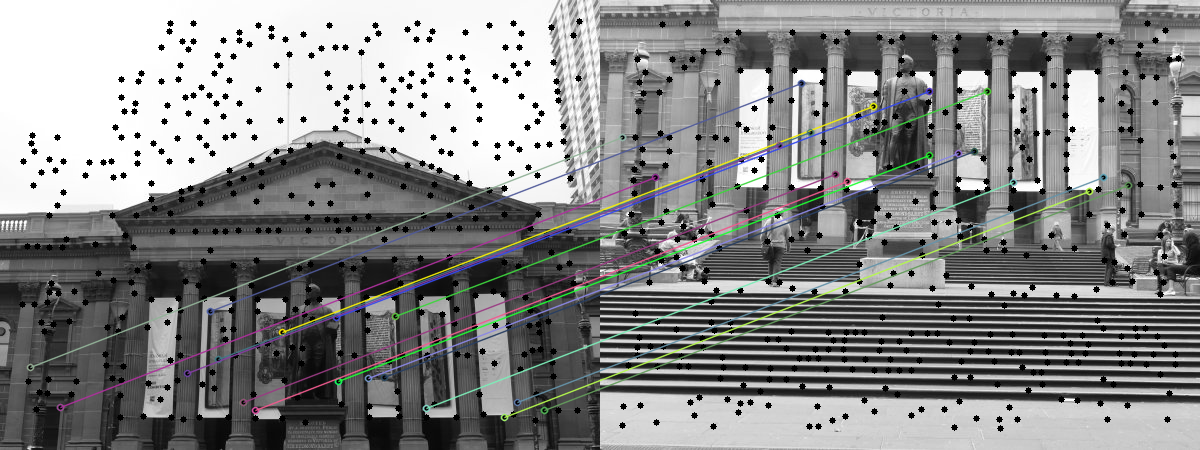

In [197]:
#Get Matches
g,key1,key2,count = Feature_Match(vec1,vec2,0.45)
print(np.shape(g))
key1 = []
key2 = []

for (a,b) in g:
    # print(a,b)
    if count[b]<2:
      key1.append([anms_corners1[a][0],anms_corners1[a][1]])
      key2.append([anms_corners2[b][0],anms_corners2[b][1]])
key1a = np.array(key1,dtype=float)
key2a = np.array(key2,dtype=float)
cv_kpts1 = [cv.KeyPoint(key1a[i][0], key1a[i][1], 1) for i in range(key1a.shape[0])]
cv_kpts2 = [cv.KeyPoint(key2a[i][0], key2a[i][1], 1) for i in range(key2a.shape[0])]
drawout = np.array([])
good_matches = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx,_distance=0) for idx in range(np.shape(key1a)[0])]
drawout = cv.drawMatches(np.uint8(gray1),cv_kpts1,np.uint8(gray2),cv_kpts2,good_matches,outImg=drawout)
# print(drawout)
cv2_imshow(drawout)


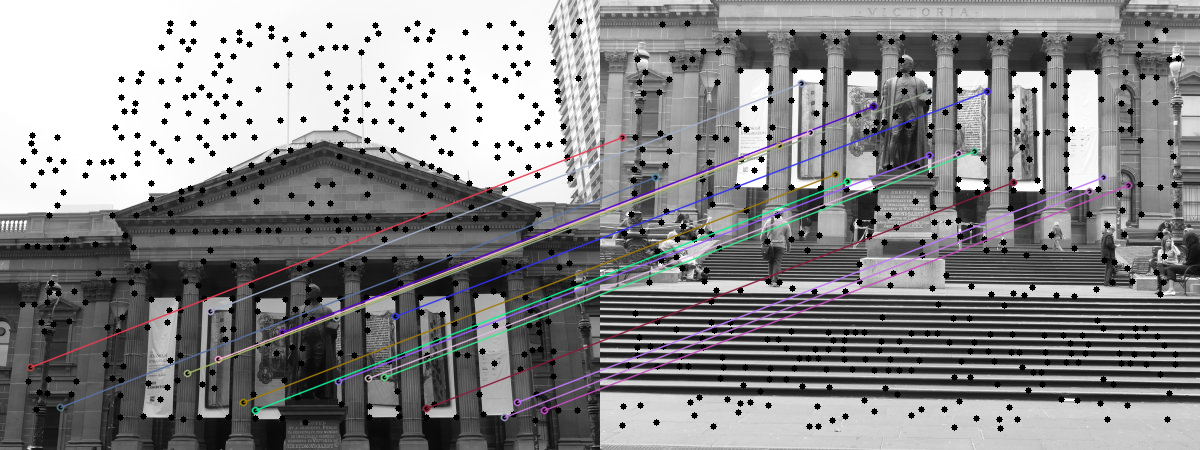

In [198]:
# RANSAC
key1b, key2b,tmf  = filterOutliers(key1a,key2a,gray1,gray2)

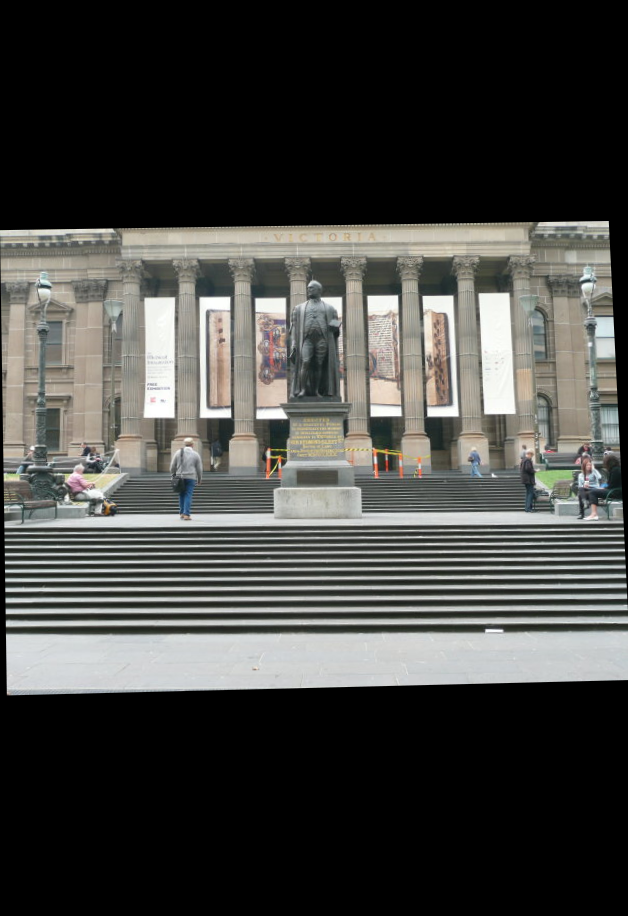

In [199]:
#Warping Image 2 wrt Image 1
stitch_12,xmin_12,ymin_12 = stitch_img(image2 ,image1, tmf)
cv2_imshow(stitch_12)

(450, 600, 3)
-2
0
(916, 628, 3)


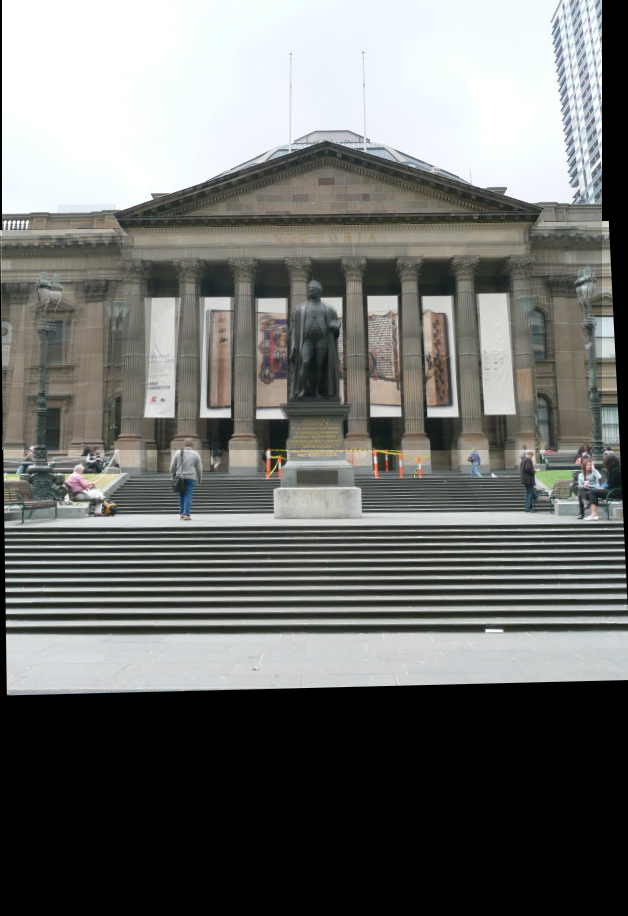

In [200]:
#Blending Image 1 and Image 2
img1 = blending(image2,image1,tmf)

In [201]:
#Read Images
image1_ = cv.imread("1 (2).jpg")
gray1_ = cv.cvtColor(image1_, cv.COLOR_BGR2GRAY)
gray1_ = cv.normalize(gray1_,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

image3 = cv.imread("3 (2).jpg")
gray3 = cv.cvtColor(image3, cv.COLOR_BGR2GRAY)
gray3 = cv.normalize(gray3,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

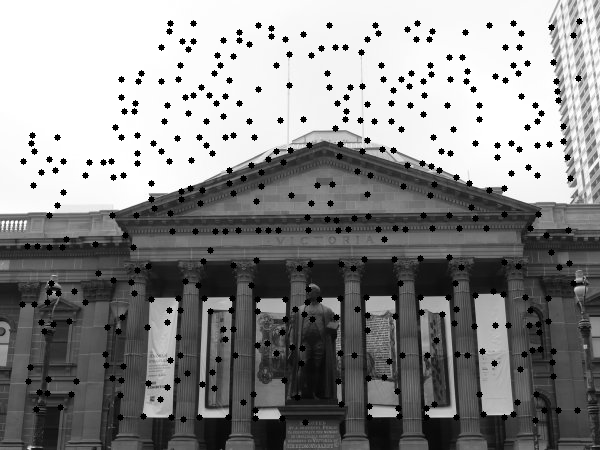

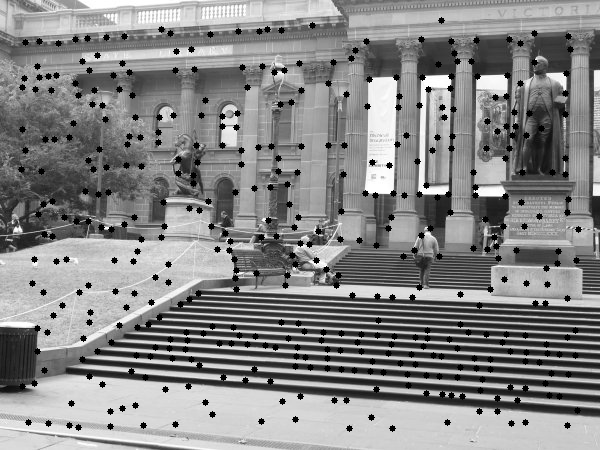

In [202]:
#Get ANMS Corners
anms_img1_, anms_corners1_ = get_ANMScorners(gray1_, 1100, 7)
anms_img3, anms_corners3 = get_ANMScorners(gray3,1100,7)

In [203]:
vec1_ = FeatureDesc(anms_corners1_,gray1_)
vec3 = FeatureDesc(anms_corners3,gray3)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

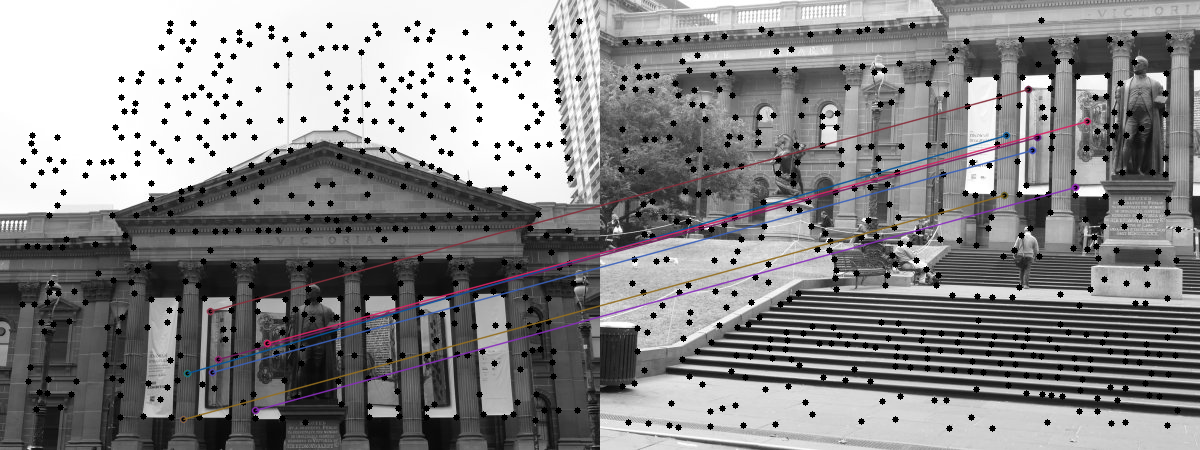

In [204]:
#Get Matches
g_,key1_,key3,count_ = Feature_Match(vec1_,vec3,0.45)
# print(np.shape(g/))
key1_ = []
key3 = []

for (a,b) in g_:
    # print(a,b)
    if count_[b]<2:
      key1_.append([anms_corners1_[a][0],anms_corners1_[a][1]])
      key3.append([anms_corners3[b][0],anms_corners3[b][1]])
key1a_ = np.array(key1_,dtype=float)
key3a = np.array(key3,dtype=float)
cv_kpts1_ = [cv.KeyPoint(key1a_[i][0], key1a_[i][1], 1) for i in range(key1a_.shape[0])]
cv_kpts3 = [cv.KeyPoint(key3a[i][0], key3a[i][1], 1) for i in range(key3a.shape[0])]
drawout_ = np.array([])
good_matches_ = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx,_distance=0) for idx in range(np.shape(key1a_)[0])]
drawout_ = cv.drawMatches(np.uint8(gray1_),cv_kpts1_,np.uint8(gray3),cv_kpts3,good_matches_,outImg=drawout_)
# print(drawout)
cv2_imshow(drawout_)

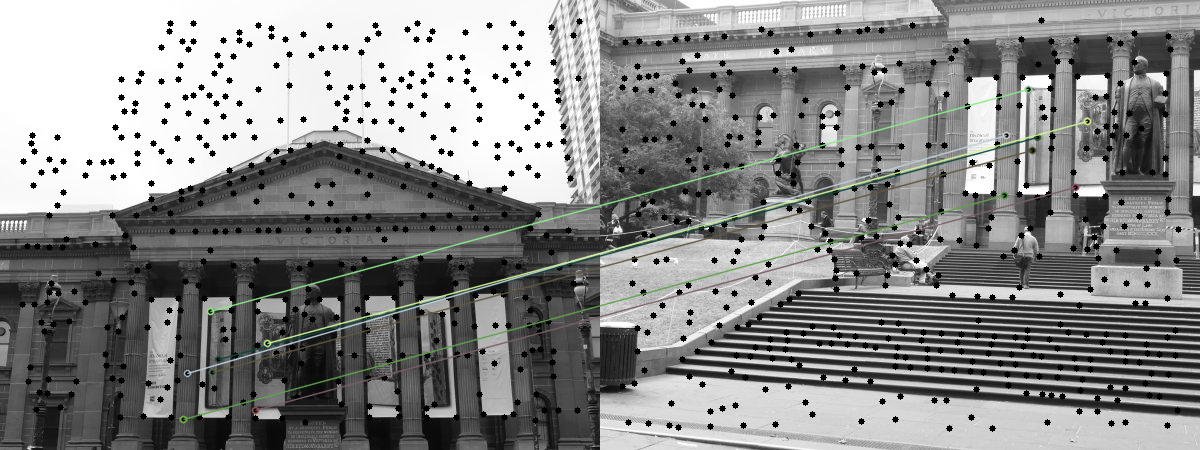

In [205]:
#RANSAC
key1b_, key3b,tmf_  = filterOutliers(key1a_,key3a,gray1_,gray3)

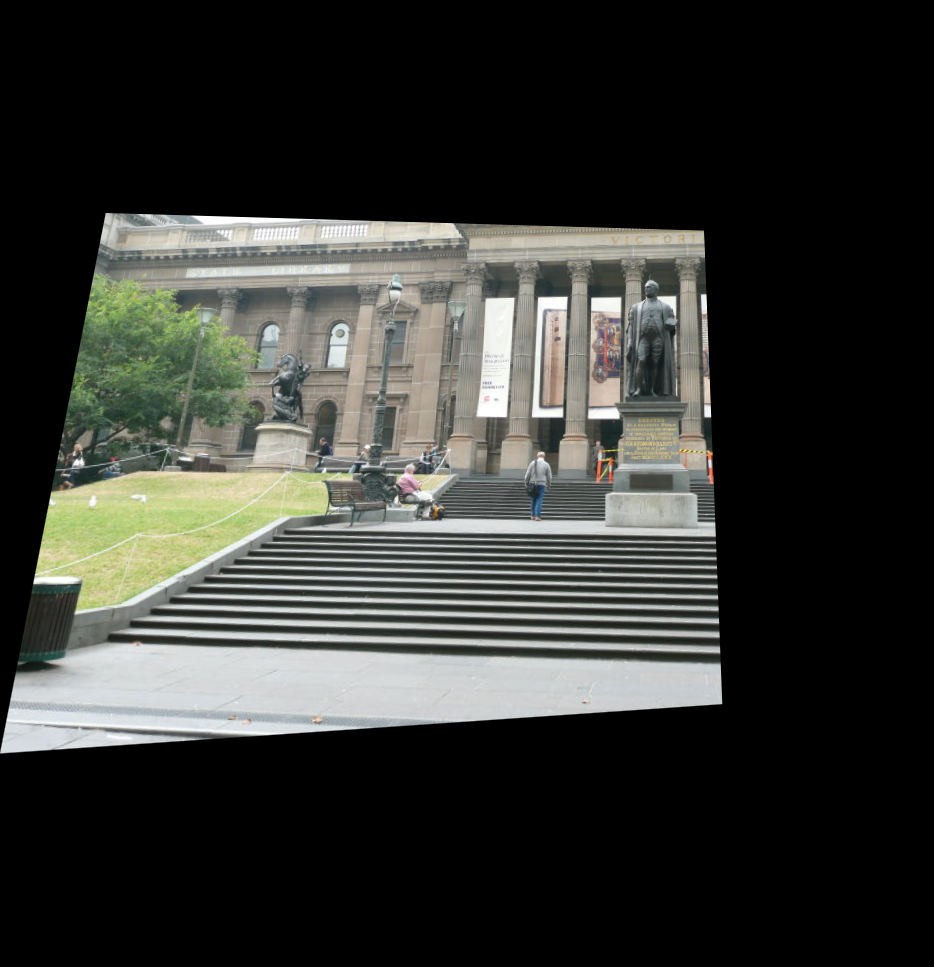

In [206]:
#Warping Image 3 wrt Image 1
stitch_13,xmin_13,ymin_13 = stitch_img(image3 ,image1, tmf_)
cv2_imshow(stitch_13)

(916, 628, 3)
-334
0
(967, 962, 3)


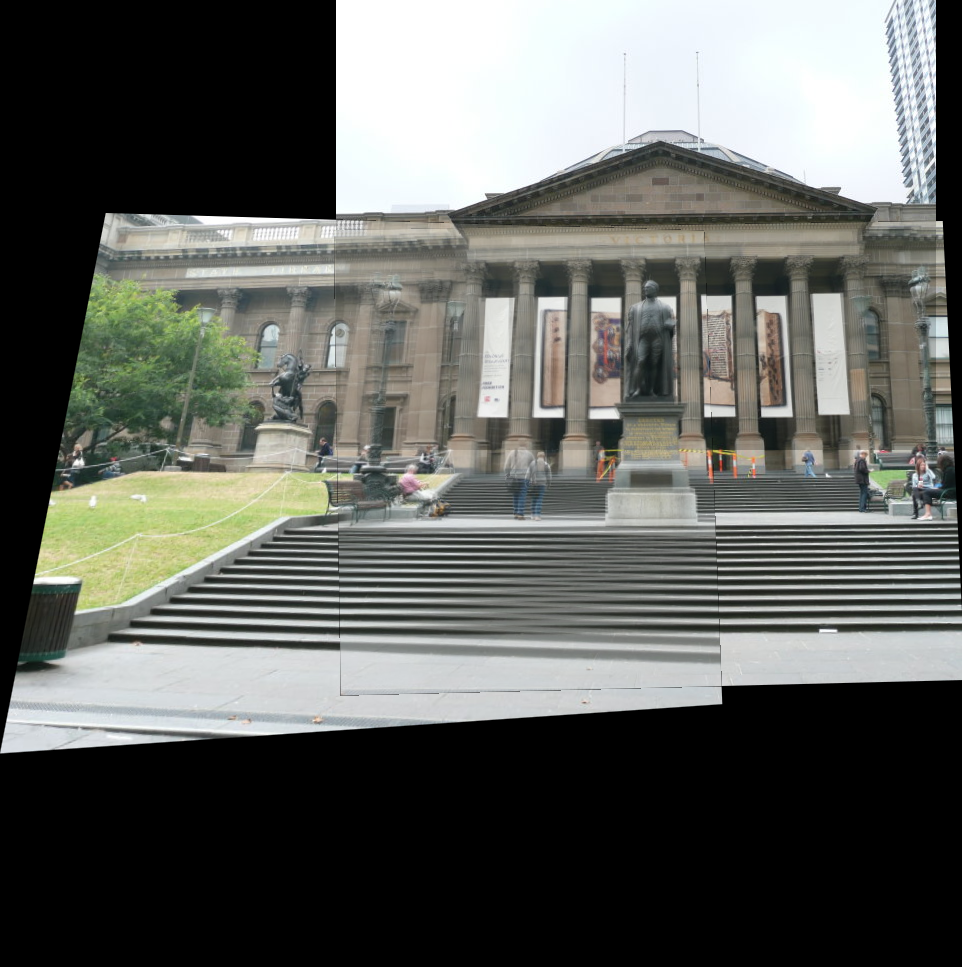

In [207]:
#Blending Image 1 and Image 2
img2 = blending(image3,img1,tmf_)

# Train Set 3:


In [ ]:
# uploaded = files.upload()

In [ ]:
# #Read Images
# image1 = cv.imread("5.jpg")  ##CONSIDER 5.jpg
# gray1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
# gray1 = cv.normalize(gray1,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

# image2 = cv.imread("6.jpg")  ##CONSIDER 6.jpg
# gray2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
# gray2 = cv.normalize(gray2,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

In [ ]:
# #Get ANMS Corners
# anms_img1, anms_corners1 = get_ANMScorners(gray1, 100, 7)
# anms_img2, anms_corners2 = get_ANMScorners(gray2,110,7)

# vec1 = FeatureDesc(anms_corners1,gray1)
# vec2 = FeatureDesc(anms_corners2,gray2)

# #Get Matches
# g,key1,key2,count = Feature_Match(vec1,vec2,0.45)
# print(np.shape(g))
# key1 = []
# key2 = []

# for (a,b) in g:
#     # print(a,b)
#     if count[b]<2:
#       key1.append([anms_corners1[a][0],anms_corners1[a][1]])
#       key2.append([anms_corners2[b][0],anms_corners2[b][1]])
# key1a = np.array(key1,dtype=float)
# key2a = np.array(key2,dtype=float)
# cv_kpts1 = [cv.KeyPoint(key1a[i][0], key1a[i][1], 1) for i in range(key1a.shape[0])]
# cv_kpts2 = [cv.KeyPoint(key2a[i][0], key2a[i][1], 1) for i in range(key2a.shape[0])]
# drawout = np.array([])
# good_matches = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx,_distance=0) for idx in range(np.shape(key1a)[0])]
# drawout = cv.drawMatches(np.uint8(gray1),cv_kpts1,np.uint8(gray2),cv_kpts2,good_matches,outImg=drawout)
# # print(drawout)
# cv2_imshow(drawout)


In [ ]:
# # #RANSAC
# key1b, key2b,tmf  = filterOutliers(key1a,key2a,gray1,gray2)

In [ ]:
# #Warping Image 2 wrt Image 1
# stitch_12,xmin_12,ymin_12 = stitch_img(image2 ,image1, tmf)
# cv2_imshow(stitch_12)

In [ ]:

# #Blending Image 1 and Image 2
# img1 = blending(image2,image1,tmf)

In [ ]:
# #Read Images
# image1_ = cv.imread("5.jpg")  ##CONSIDER 5.jpg
# gray1_ = cv.cvtColor(image1_, cv.COLOR_BGR2GRAY)
# gray1_ = cv.normalize(gray1_,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

# image3 = cv.imread("4.jpg")  ##CONSIDER 4.jpg
# gray3 = cv.cvtColor(image3, cv.COLOR_BGR2GRAY)
# gray3 = cv.normalize(gray3,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

In [ ]:
# #Get ANMS Corners
# anms_img1_, anms_corners1_ = get_ANMScorners(gray1_, 110, 7)
# anms_img3, anms_corners3 = get_ANMScorners(gray3,100,7)

In [ ]:
# vec1_ = FeatureDesc(anms_corners1_,gray1_)
# vec3 = FeatureDesc(anms_corners3,gray3)

In [ ]:

# #Get Matches
# g_,key1_,key3,count_ = Feature_Match(vec1_,vec3,0.45)
# # print(np.shape(g/))
# key1_ = []
# key3 = []

# for (a,b) in g_:
#     # print(a,b)
#     if count_[b]<2:
#       key1_.append([anms_corners1_[a][0],anms_corners1_[a][1]])
#       key3.append([anms_corners3[b][0],anms_corners3[b][1]])
# key1a_ = np.array(key1_,dtype=float)
# key3a = np.array(key3,dtype=float)
# cv_kpts1_ = [cv.KeyPoint(key1a_[i][0], key1a_[i][1], 1) for i in range(key1a_.shape[0])]
# cv_kpts3 = [cv.KeyPoint(key3a[i][0], key3a[i][1], 1) for i in range(key3a.shape[0])]
# drawout_ = np.array([])
# good_matches_ = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx,_distance=0) for idx in range(np.shape(key1a_)[0])]
# drawout_ = cv.drawMatches(np.uint8(gray1_),cv_kpts1_,np.uint8(gray3),cv_kpts3,good_matches_,outImg=drawout_)
# # print(drawout)
# cv2_imshow(drawout_)

In [ ]:
# #RANSAC
# key1b_, key3b,tmf_  = filterOutliers(key1a_,key3a,gray1_,gray3)

In [ ]:
# #Warping Image 3 wrt Image 1
# stitch_13,xmin_13,ymin_13 = stitch_img(image3 ,image1, tmf_)
# cv2_imshow(stitch_13)

In [ ]:
# #Blending Image 1 Image 2and Image 3
# img2 = blending(image3,img1,tmf_)

Test Set1:


In [164]:
# uploaded = files.upload()

In [165]:
# #Read Images
# image1 = cv.imread("2 (1).jpg") ####CONSIDER 2.jpg
# gray1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
# gray1 = cv.normalize(gray1,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

# image2 = cv.imread("1 (1).jpg") ####CONSIDER 1.jpg
# gray2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
# gray2 = cv.normalize(gray2,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)


In [166]:
# #Get ANMS Corners
# anms_img1, anms_corners1 = get_ANMScorners(gray1, 250, 7)
# anms_img2, anms_corners2 = get_ANMScorners(gray2,250,7)

# vec1 = FeatureDesc(anms_corners1,gray1)
# vec2 = FeatureDesc(anms_corners2,gray2)

# #Get Matches
# g,key1,key2,count = Feature_Match(vec1,vec2,0.45)
# print(np.shape(g))
# key1 = []
# key2 = []

# for (a,b) in g:
#     # print(a,b)
#     if count[b]<2:
#       key1.append([anms_corners1[a][0],anms_corners1[a][1]])
#       key2.append([anms_corners2[b][0],anms_corners2[b][1]])
# key1a = np.array(key1,dtype=float)
# key2a = np.array(key2,dtype=float)
# cv_kpts1 = [cv.KeyPoint(key1a[i][0], key1a[i][1], 1) for i in range(key1a.shape[0])]
# cv_kpts2 = [cv.KeyPoint(key2a[i][0], key2a[i][1], 1) for i in range(key2a.shape[0])]
# drawout = np.array([])
# good_matches = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx,_distance=0) for idx in range(np.shape(key1a)[0])]
# drawout = cv.drawMatches(np.uint8(gray1),cv_kpts1,np.uint8(gray2),cv_kpts2,good_matches,outImg=drawout)
# # print(drawout)
# cv2_imshow(drawout)


In [167]:
# # #RANSAC
# key1b, key2b,tmf  = filterOutliers(key1a,key2a,gray1,gray2)

# #Warping Image 2 wrt Image 1
# stitch_12,xmin_12,ymin_12 = stitch_img(image2 ,image1, tmf)
# cv2_imshow(stitch_12)
# #Blending Image 1 and Image 2
# img1 = blending(image2,image1,tmf)

### CUSTOM SET 1:


In [12]:
# uploaded = files.upload()

In [13]:
# #Read Images
# image1 = cv.imread("custom1.jpg") ###CONSIDER custom1.jpg
# image1 = cv.resize(image1, (408,307), interpolation  = cv.INTER_LINEAR)

# gray1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
# # print(np.shape(gray1))
# # print(np.shape(gray1))

# # gray1 = cv.normalize(gray1,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

# image2 = cv.imread("custom2.jpg") ##CONSIDER custom2.jpg
# image2 = cv.resize(image2, (408,307), interpolation  = cv.INTER_LINEAR)

# gray2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
# gray2 = cv.normalize(gray2,dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)

# # print(np.shape(gray2))


In [14]:
# #Get ANMS Corners
# anms_img1, anms_corners1 = get_ANMScorners(gray1, 80, 5)
# anms_img2, anms_corners2 = get_ANMScorners(gray2,80,5)

# vec1 = FeatureDesc(anms_corners1,gray1)
# vec2 = FeatureDesc(anms_corners2,gray2)

# #Get Matches
# g,key1,key2,count = Feature_Match(vec1,vec2,0.45)
# print(np.shape(g))
# key1 = []
# key2 = []

# for (a,b) in g:
#     # print(a,b)
#     if count[b]<2:
#       key1.append([anms_corners1[a][0],anms_corners1[a][1]])
#       key2.append([anms_corners2[b][0],anms_corners2[b][1]])
# key1a = np.array(key1,dtype=float)
# key2a = np.array(key2,dtype=float)
# cv_kpts1 = [cv.KeyPoint(key1a[i][0], key1a[i][1], 1) for i in range(key1a.shape[0])]
# cv_kpts2 = [cv.KeyPoint(key2a[i][0], key2a[i][1], 1) for i in range(key2a.shape[0])]
# drawout = np.array([])
# good_matches = [cv.DMatch(_imgIdx=0, _queryIdx=idx, _trainIdx=idx,_distance=0) for idx in range(np.shape(key1a)[0])]
# drawout = cv.drawMatches(np.uint8(gray1),cv_kpts1,np.uint8(gray2),cv_kpts2,good_matches,outImg=drawout)
# # print(drawout)
# cv2_imshow(drawout)


In [15]:
# # #RANSAC
# key1b, key2b,tmf  = filterOutliers(key1a,key2a,gray1,gray2)

# #Warping Image 2 wrt Image 1
# stitch_12,xmin_12,ymin_12 = stitch_img(image2 ,image1, tmf)
# cv2_imshow(stitch_12)
# #Blending Image 1 and Image 2
# img1 = blending(image2,image1,tmf)